# Setup

In [1]:
%pylab inline

import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
WLFF = '/Users/Ismael/code/lensing/WLFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#inputs, put all input files in a dict, 
inputs = dict(
input_fits = '/Users/Ismael/temp_data/final_fits.fits',
)

### Robust statistics

In [3]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

### Samples

In [4]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(abs(cat['bias_g1']) < bias_cut) & (abs(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(abs(cat['bias_g1_grp']) < bias_cut) & (abs(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut: cat[abs(cat[param]) < cut]
unphysical_iso = lambda cat: cat[(abs(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(abs(cat['bias_g1_grp']) > 1.) | (abs(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

In [5]:
#smaller random samples 
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

#get a smaller sample of each of the catalogs for illustrative purposes 
small = lambda cat,N: leaveRandom(N, cat)

### Read files. 

In [6]:
results = fits.open(inputs['input_fits'])
hdr = results[0].header
cat = astropy.table.Table.read(results,hdu=1)


In [7]:
cat

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402703800921,402700070321,14,4,1,63,78,4435,4449,0.979957,0.0200425,-435.79,438.548,1.10249,25.118,0.304281,100951.0,0.280908,0.287157,0.107846,0.10181,0.326177,0.241922,0.378307,0.679782,0.99283,17.62,17.5798,17.5797,11.6366,11.55,0.20813,0.189111,0.188379,0.209643,0.189235,0.189312,nan,nan,nan,0.0,2.98023e-09,885.573,-0.0536606,0.019716,0.0186084,1.20218e-06,2.17978e-07,846.358,-0.0550999,0.0196308,0.0200551,0.000114121,-6.89414e-05,15338,False
402711741705,402700070321,14,11,1,48,56,4441,4450,1.0,0.0,-439.49,439.268,1.7324,27.0767,0.483753,16619.1,0.136951,0.169101,-0.412124,-0.194816,0.224008,0.0837271,-1.35001,0.638975,0.708771,3.35006,3.34837,3.34785,2.3052,2.10892,5.09399,4.65826,2.87848,5.24664,4.72975,2.9207,nan,nan,nan,0.0,0.0,5632.62,-42.2587,-45.489,-21.5245,-0.00060437,0.00156415,6098.27,-43.7503,-47.4022,-22.59,0.00227608,0.00415418,-1,False
402700888931,402700157436,6,1,1,-10,12,4426,4445,0.984052,0.0159475,-449.739,437.212,0.564225,23.3659,0.708736,506909.0,0.312205,0.373293,0.247482,-0.339966,0.488806,0.199409,-0.470774,0.714129,0.998528,84.9669,84.0811,84.0808,55.8643,55.8625,0.0537954,0.0384234,0.0448485,0.0537965,0.0384241,0.0448489,nan,nan,nan,0.0,2.98023e-09,186.334,-0.00364419,0.00243869,-0.00335012,-1.38445e-09,3.24792e-09,186.15,-0.00364542,0.00243957,-0.0033502,-4.33745e-08,9.07668e-08,15137,False
402700157436,402700157436,6,0,1,-7,36,4403,4437,0.979011,0.0209888,-446.944,434.097,0.978547,21.2337,0.357725,3.61274e+06,0.552112,0.642985,0.384919,-0.0551429,0.8323,0.366247,-0.0711453,0.861934,0.999263,469.728,449.528,449.527,289.384,285.028,0.00562225,0.00499328,0.00350777,0.00576322,0.00512956,0.00352524,nan,nan,nan,0.0,2.98023e-09,39.0377,-2.74528e-05,2.98148e-05,-4.27184e-06,-2.55419e-11,1.85468e-11,-102.075,-0.000102954,9.69304e-05,-2.51873e-05,3.9072e-06,1.3913e-05,15146,False
402710043179,402700157436,6,4,1,14,25,4437,4447,1.0,0.0,-445.995,438.466,1.9369,26.7302,-0.0148411,22866.9,0.338655,0.342763,0.102475,0.039454,0.378129,0.303302,0.183759,0.705051,0.999558,3.72547,3.72377,3.72377,2.31122,2.31122,0.860507,0.774936,0.7525,0.860507,0.774936,0.7525,nan,nan,nan,0.0,0.0,5915.07,-0.647236,0.259546,0.0999777,0.000937364,-0.000385944,5915.08,-0.647236,0.259546,0.0999779,0.000937307,-0.000386045,-1,False
402716543735,402716543735,1,0,1,2,9,4360,4367,1.0,0.0,-448.769,422.796,3.06535,27.8187,-0.0392017,8391.27,0.151304,0.160452,0.209959,-0.120637,0.193707,0.118183,-0.260758,0.637054,1.0,1.67006,1.66963,1.66963,1.07274,1.07274,5.62974,5.15311,4.59607,5.62974,5.15311,4.59607,nan,nan,nan,0.0,0.0,15828.7,-49.7808,35.6115,-20.6862,0.0143205,0.00312236,15828.7,-49.7808,35.6115,-20.6862,0.0143205,0.00312236,-1,False
402700326587,402700326587,11,0,1,19,48,4373,4405,0.958816,0.0411839,-443.197,427.862,0.55267,22.4916,0.557438,1.13411e+06,0.611041,0.643435,-0.103375,0.2023,0.769992,0.484903,1.0216,0.879698,0.938179,139.122,137.324,137.273,83.7917,60.7617,0.0165666,0.0129921,0.0139023,0.0204651,0.0144399,0.0186831,nan,nan,nan,0.0,2.98023e-09,140.606,-0.000181832,-6.36296e-05,0.000124498,-1.26983e-09,-4.54258e-09,-1012.5,-0.00149075,0.000156636,0.000660477,7.71152e-05,3.09066e-06,15393,True
402709202217,402700326587

In [8]:
#rename some header things 
hdr.rename_keyword('E_HEIGHT','IMAGE_HEIGHT')
hdr.rename_keyword('GE_WIDTH','IMAGE_WIDTH')
hdr.rename_keyword('EL_SCALE','PIXEL_SCALE')
hdr.rename_keyword('TER_BAND','FILTER_BAND')

hdr.keys() #check 

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'NSLICES',
 'PSF_SIGM',
 'PSF_SIGP',
 'PSF_HSM',
 'URE_TIME',
 'IGHTNESS',
 'DIAMETER',
 'AIRMASS',
 'RO_POINT',
 'VEY_NAME',
 'IMAGE_WIDTH',
 'FILTER_BAND',
 'PIXEL_SCALE',
 'PSF_BETA',
 'SHEAR_G2',
 'PSF_FWHM',
 'IMAGE_HEIGHT',
 'IVE_AREA',
 'TINCTION',
 'C_PSF_E1',
 'SHEAR_G1',
 'C_PSF_E2']

In [9]:
print len(cat)

53899


# Analysis Results 

### Percetage of samples from total 

In [27]:
#print float(len(ambig(cat)))/len(cat)
print 'Fraction of detected & not ambiguous objects: {0:.3g}%'.format(float(len(detc_and_notambig(cat)))/len(cat)*100)
print 'Fraction of detected & ambiguous objects: {0:.3g}%'.format(float(len(detc_and_ambig(cat)))/len(cat)*100)
print 'Fraction of not detected & ambiguous objects: {0:.3g}%'.format(float(len(notdetc_and_ambig(cat)))/len(cat)*100)
print 'Fraction of not detected & not ambiguous objects: {0:.3g}%'.format(float(len(notdetc_and_notambig(cat)))/len(cat)*100)


Fraction of detected & not ambiguous objects: 22.9%
Fraction of detected & ambiguous objects: 7.26%
Fraction of not detected & ambiguous objects: 8.54%
Fraction of not detected & not ambiguous objects: 61.3%


### How does our best sample look with respect to the golden one, 

0.661140315406


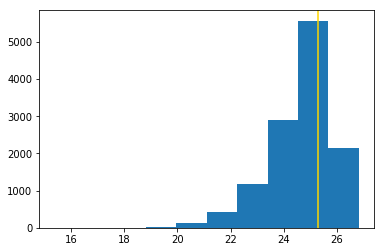

In [28]:
plt.hist(detected(not_ambig(cat))['ab_mag'])
plt.axvline(25.3,color='gold')
print float(len(gold(detected(not_ambig(cat)))))/len(detected(not_ambig(cat)))
#only around 66% are golden. 

### What percentage of objects in best sample have unphysical bias? 

In [29]:
sample = detected(not_ambig(cat))
print float(len(unphysical_grp(sample)))/len(sample)

0.160776384958


### What percentage of unphysical bias of our best sample comes from the dim ones? 

In [30]:
sample = detected(not_ambig(cat))
float(len(up_cut(unphysical_grp(sample),'ab_mag',25.3)))/len(unphysical_grp(sample))
#~80% 
#the others? - limit of ambig vs not_ambig blending? 

0.795774647887324

### Other plots comparing samples. 

In [15]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_cumhists(name,cat,colors,g_min,g_max,save=None):
    plt.title(name,fontsize=20)
    plt.xlabel('absolute bias on g1',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(np.absolute(cat['bias_g1']),range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1']))/len(cat['bias_g1']))
    plt.hist(np.absolute(cat['bias_g1_grp']),range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1_grp']))/len(cat['bias_g1_grp']))
    #plt.yscale('log')
#     plt.ylim(0,1.)

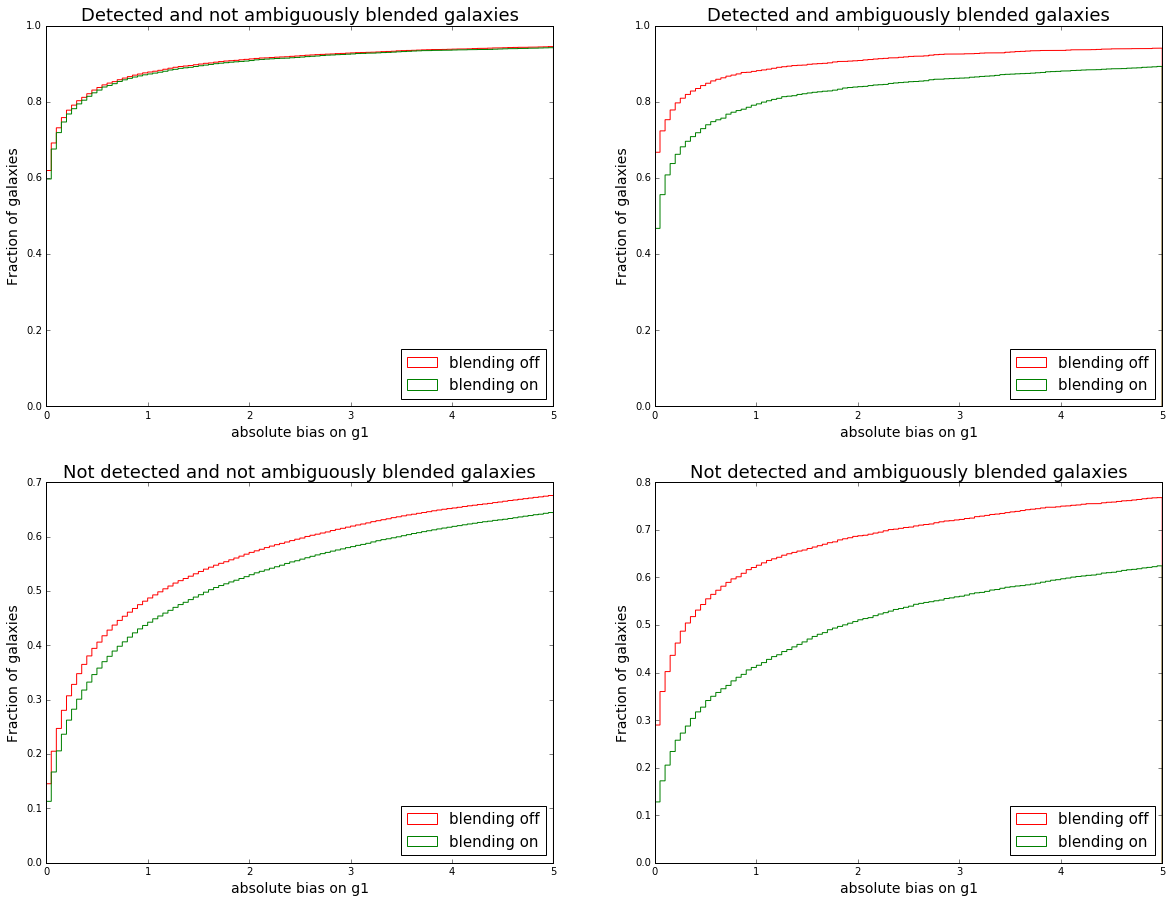

In [40]:
g_min = 0. 
g_max = 5.
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]
colors = ('red','green')
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15},loc=4)

In [31]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_hists(name,cat,colors,g_min,g_max,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    
    #annotate 
    mean_cut_iso = np.mean(cut_biasiso(cat_temp,10.)['bias_g1'])
    std_cut_iso = np.std(cut_biasiso(cat_temp,10.)['bias_g1'])
    median_iso = np.median(cat_temp['bias_g1'])
    mad_iso = mad(cut_biasiso(cat_temp,10.)['bias_g1'])
    error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat_temp,10)))
    error_mad_iso = mad_iso/np.sqrt(len(cut_biasiso(cat_temp,10.)['bias_g1']))
    
    mean_cut_grp = np.mean(cut_biasgrp(cat_temp,10)['bias_g1_grp'])
    std_cut_grp = np.std(cut_biasgrp(cat_temp,10)['bias_g1_grp'])
    median_grp = np.median(cat_temp['bias_g1_grp'])
    mad_grp = mad(cut_biasgrp(cat_temp,10)['bias_g1_grp'])
    error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat_temp,10)))
    error_mad_grp = mad_grp/np.sqrt(len(cut_biasgrp(cat_temp,10)['bias_g1_grp']))
    
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('MAD (using cut): {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('MAD (using cut): {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=12)

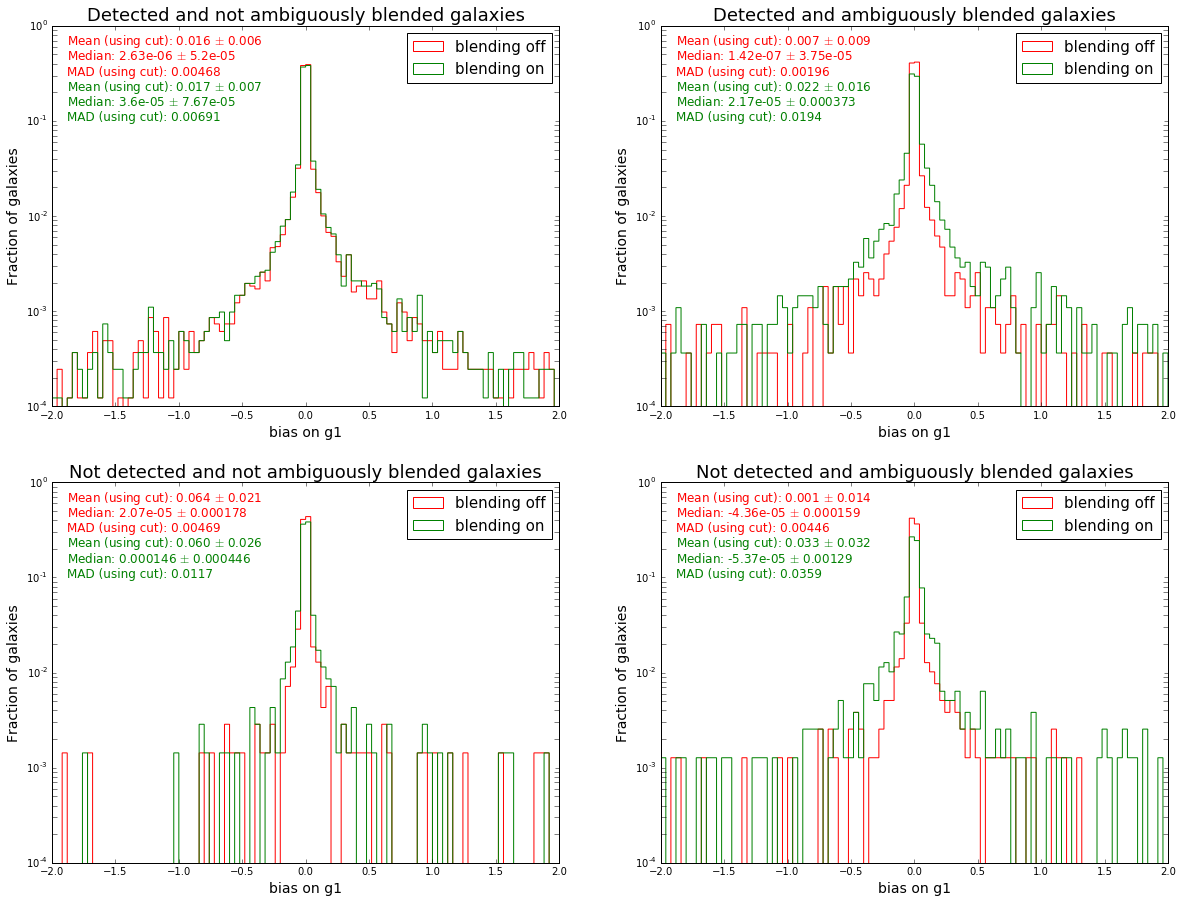

In [34]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2
g_min = -2. 
g_max = 2.
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(gold(cat)),detc_and_ambig(gold(cat)),notdetc_and_notambig(gold(cat)),notdetc_and_ambig(gold(cat))]
colors = ('red','green')
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})


In [19]:
#produce different plots with the biases calculated from the fisher formalism. 
def ellipticity_hist(name,cat,color,g_min,g_max,save=None):
    plt.title('Ellipticity distribution for the different galaxy samples',fontsize=18)
    plt.xlabel('ellipticity e1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['e1'],range=[g_min,g_max],bins=50,histtype='step',label=name,color=color,weights=np.ones_like(cat['e1'])/len(cat['e1']))
    std = np.std(cat_temp['e1'])
    std_error = std/np.sqrt(2*len(cat_temp['e1']))
    plt.annotate('Std for {0}: {1:.3g} $\pm$ {2:.3f}'.format(name_std,std,std_error), xy=(0.01, 0.95-.02*i), xycoords='axes fraction',color=color,fontsize=14)


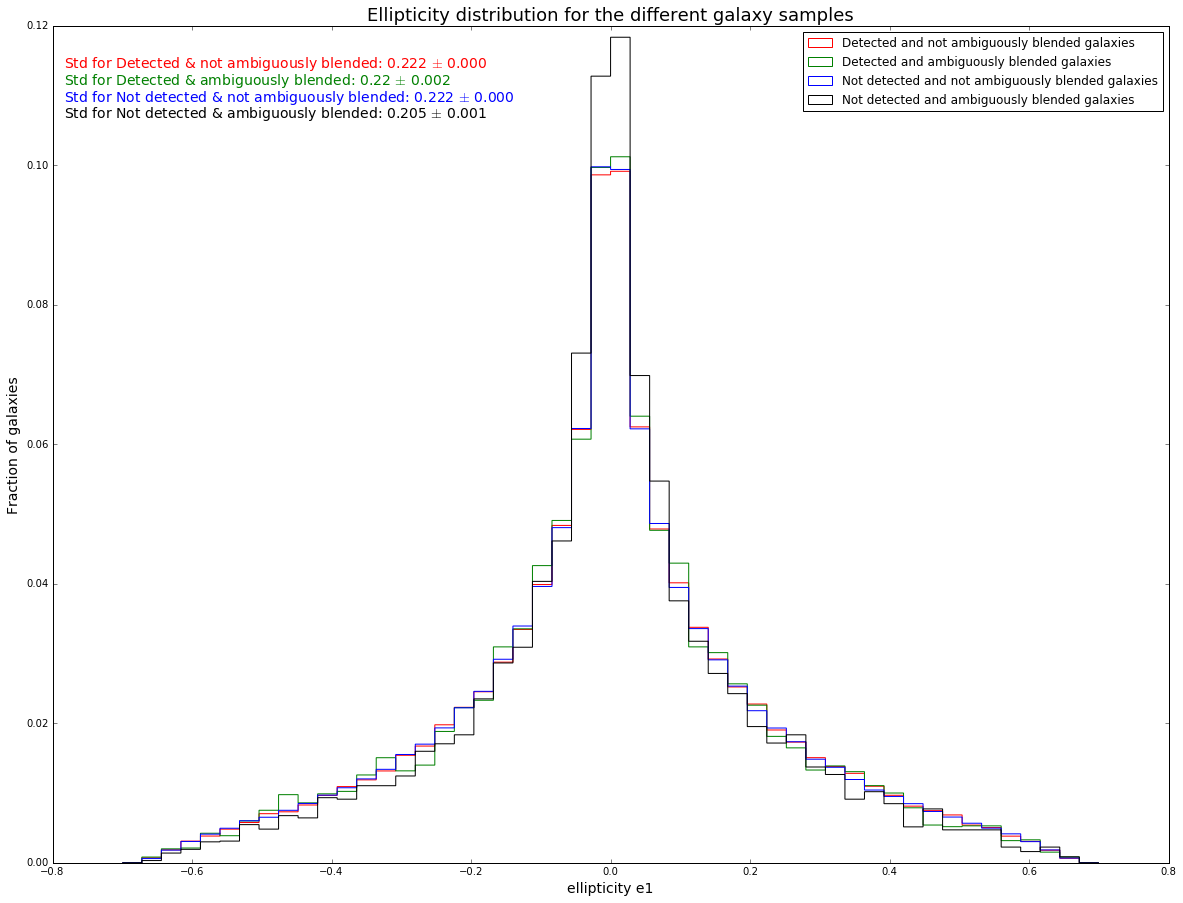

In [20]:
fig = plt.figure(figsize=(20,15))
g_min = -.7 
g_max = .7

names_stds = ['Detected & not ambiguously blended','Detected & ambiguously blended','Not detected & not ambiguously blended','Not detected & ambiguously blended']
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]
colors = ('red','green','blue','black')
for i,(cat_temp,color,name,name_std) in enumerate(zip(cats,colors,names,names_stds)):
    ellipticity_hist(name,cat_temp,color,g_min,g_max)
    plt.legend(prop={'size':12})

In [31]:
#produce different plots with the biases calculated from the fisher formalism. 
def purity_snr_scatter(name,cat,colors,full_cat,save=None):
    #divide into 4 groups 
    high_pur_high_snr = up_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = down_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = up_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = down_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(cat)
    p2 = float(len(high_pur_low_snr))/len(cat)
    p3 = float(len(low_pur_high_snr))/len(cat)
    p4 = float(len(low_pur_low_snr))/len(cat)


    #plot each group separately with different colors 
    plt.scatter(high_pur_high_snr['snr_grpf'],high_pur_high_snr['purity'],alpha=.3,color=colors[0])
    plt.scatter(high_pur_low_snr['snr_grpf'],high_pur_low_snr['purity'],alpha=.3,color=colors[1])
    plt.scatter(low_pur_high_snr['snr_grpf'],low_pur_high_snr['purity'],alpha=.3,color=colors[2])
    plt.scatter(low_pur_low_snr['snr_grpf'],low_pur_low_snr['purity'],alpha=.3,color=colors[3])

    #annotate with colors the percentages
    plt.annotate('High purity & high snr: {0:.3g}%'.format(p1*100), xy=(0.55, 0.17), xycoords='axes fraction',color=colors[0],fontsize=14)
    plt.annotate('High purity & low snr: {0:.3g}%'.format(p2*100), xy=(0.55, 0.13), xycoords='axes fraction',color=colors[1],fontsize=14)
    plt.annotate('Low purity & high snr: {0:.3g}%'.format(p3*100), xy=(0.55, 0.09), xycoords='axes fraction',color=colors[2],fontsize=14)
    plt.annotate('Low purity & Low snr: {0:.3g}%'.format(p4*100), xy=(0.55, 0.05), xycoords='axes fraction',color=colors[3],fontsize=14)
    plt.annotate('Fraction of full catalogue: {0:.3g}%'.format(float(len((cat)))/len(full_cat)*100), xy=(0.55, 0.01), xycoords='axes fraction',color=colors[4],fontsize=14)


    
    plt.title(name,fontsize=18)
    plt.xlabel(r'$\nu_{grpf}$',fontsize=20)
    plt.ylabel('Purity',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.xlim(0,30)
    plt.ylim(0.,1.)

NameError: name 'purity_snr_scatter' is not defined

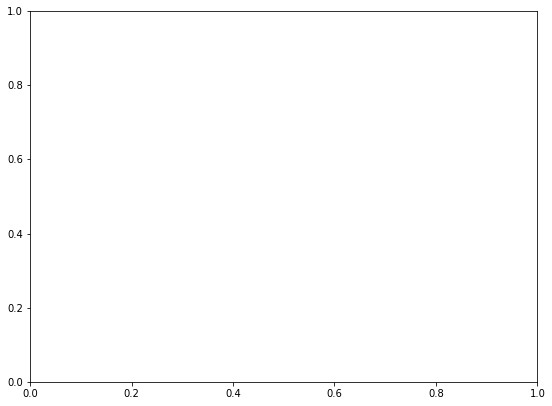

In [12]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2

names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]
colors= ['red', 'green', 'blue', 'plum','black']

for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    purity_snr_scatter(name,cat_temp,colors,cat)
    plt.axhline(.98,color='red',linewidth=2)
    plt.axvline(6,color='red',linewidth=2)
    plt.xlim(0,30)

### Compare whole catalogue and best sample for poster. 

In [49]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_cumhistsPoster(name,cat,colors,g_min,g_max,save=None):
#     plt.title(name,fontsize=20)
    plt.xlabel('absolute bias on g1',fontsize=50)
    plt.ylabel('Fraction of galaxies',fontsize=50)
    plt.tick_params(axis='both', which='major',labelsize=30,size=10,width=3)
    plt.hist(np.absolute(cat['bias_g1']),range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],lw=3,cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1']))/len(cat['bias_g1']))
    plt.hist(np.absolute(cat['bias_g1_grp']),range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',lw=3,cumulative=True,weights=np.ones_like(np.absolute(cat['bias_g1_grp']))/len(cat['bias_g1_grp']))
    #plt.yscale('log')
#     plt.ylim(0,1.)

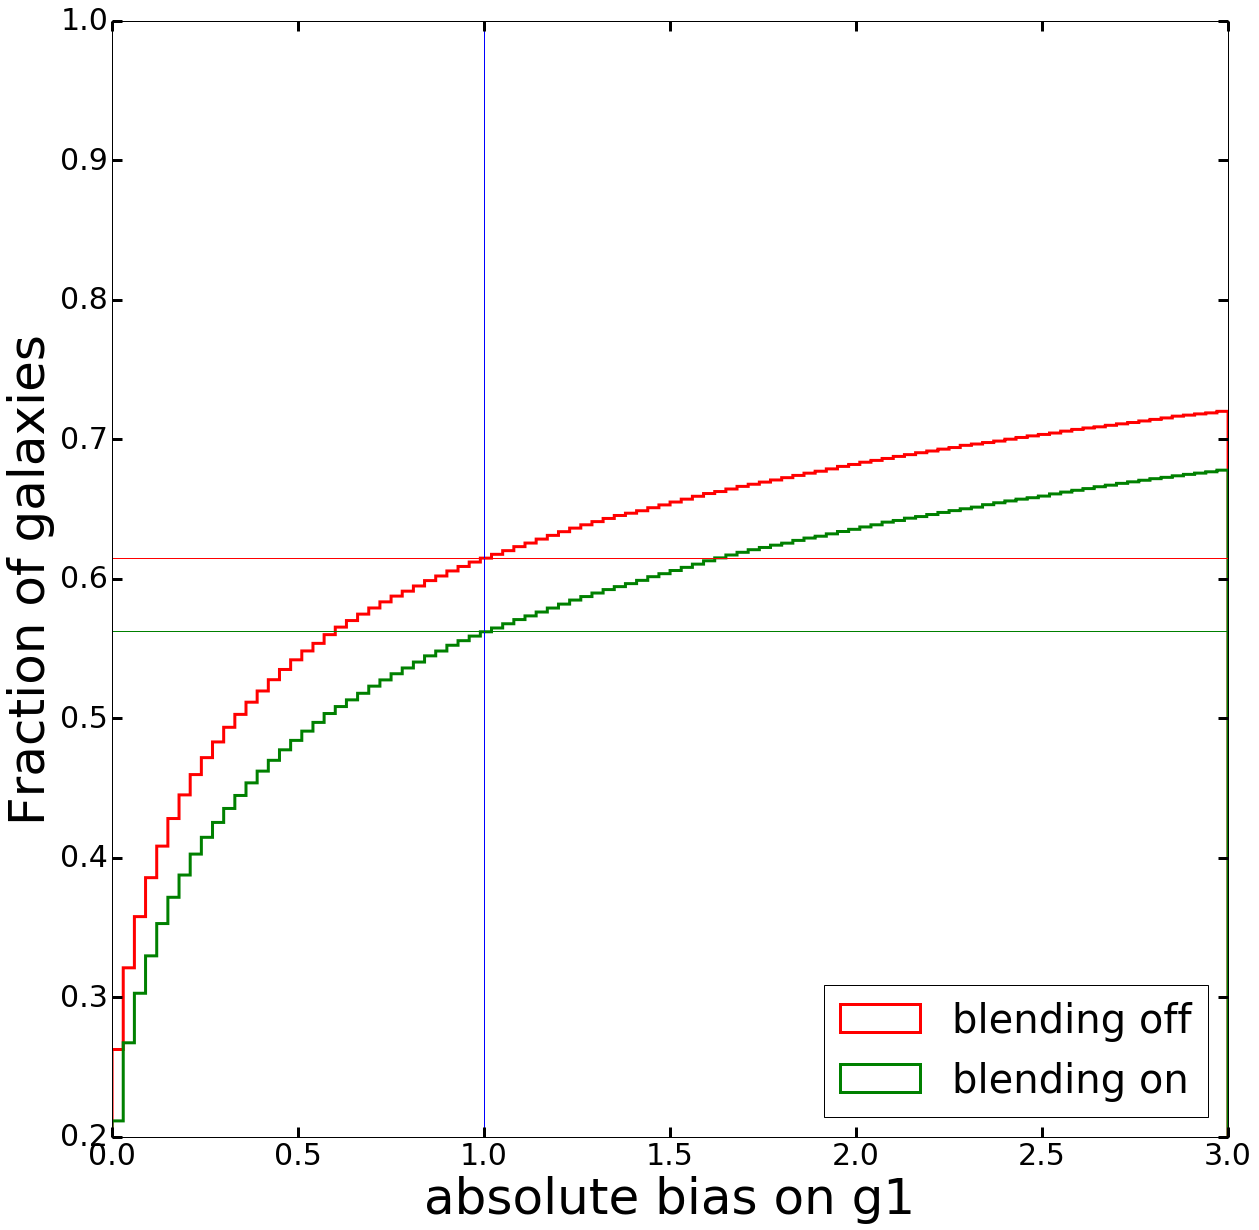

In [50]:
names = ['All galaxies']
cats =[cat]
colors = ('red','green')
fig = plt.figure(figsize=(20,20))
nrow,ncol = 1,1
g_min = 0. 
g_max = 3.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhistsPoster(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':40},loc=4)
    plt.ylim(.2,1.)
    plt.axvline(1.,color='blue')
    plt.axhline(.615,color='red')
    plt.axhline(.5625,color='green')
    fig.savefig('/Users/Ismael/Desktop/cumulative_plots1.pdf')

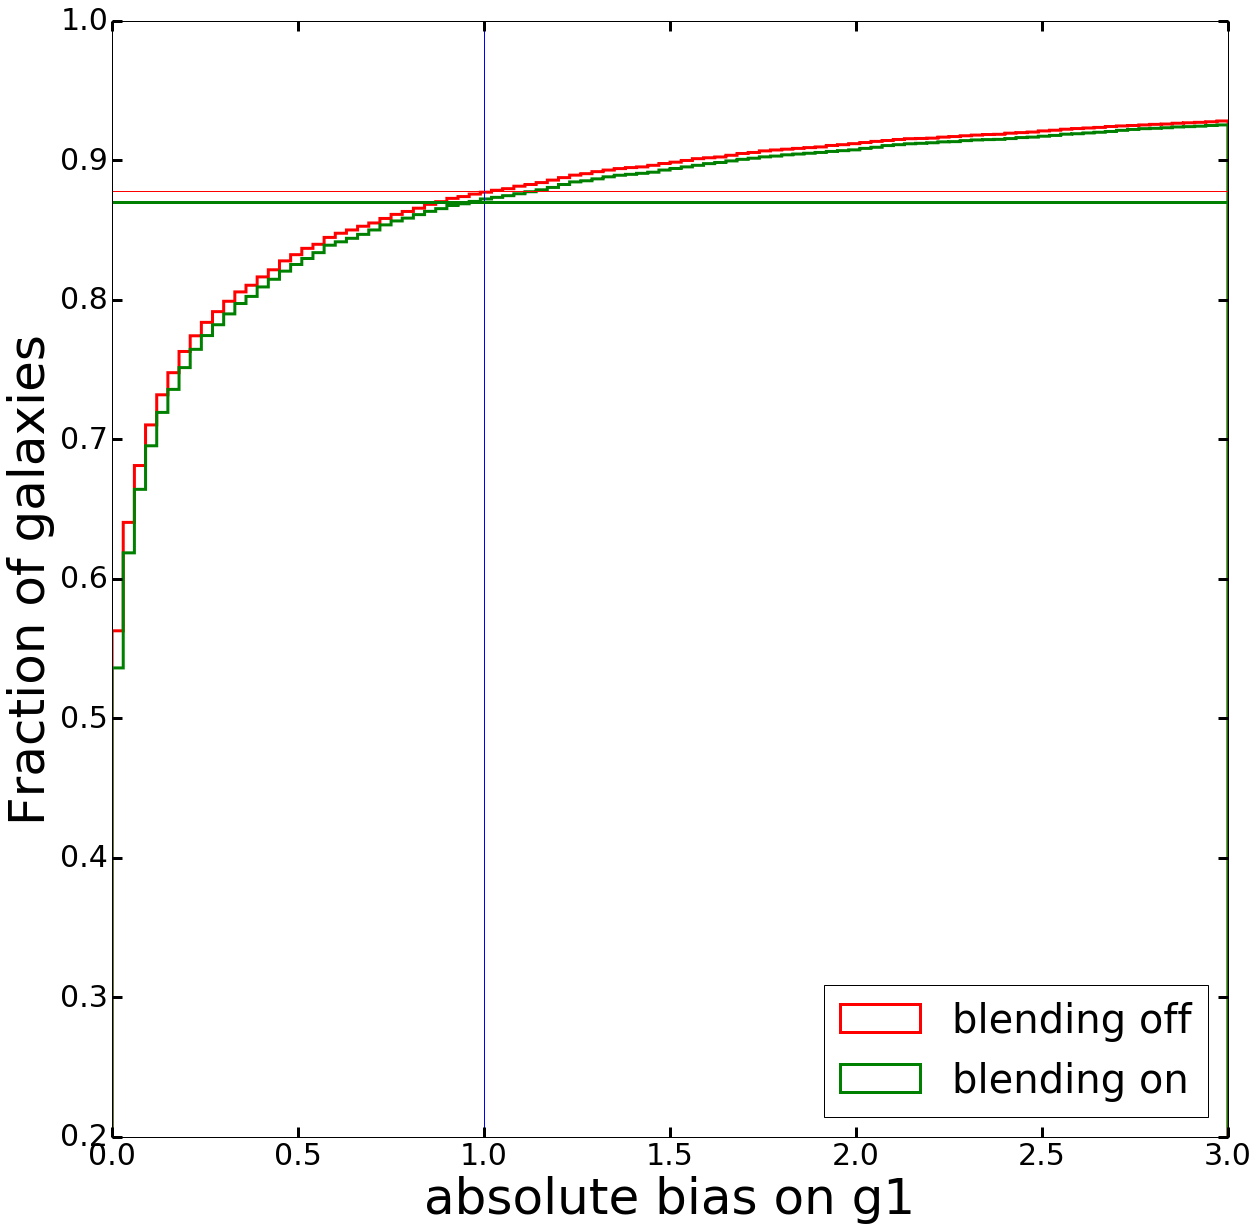

In [51]:
names = ['Not Ambiguously blended and Detected galaxies']
cats =[best(cat)]
colors = ('red','green')
fig = plt.figure(figsize=(20,20))
nrow,ncol = 1,1
g_min = 0. 
g_max = 3.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhistsPoster(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':40},loc=4)
    plt.ylim(.2,1.)
    plt.axvline(1.,color='blue')
    plt.axhline(.878,color='red')
    plt.axhline(.87,color='green',linewidth=3)
    fig.savefig('/Users/Ismael/Desktop/cumulative_plots2.pdf')

In [61]:
#produce different plots with the biases calculated from the fisher formalism. 
def purity_snr_scatter_poster(name,cat,colors,power,full_cat,ax,save=None):
    #divide into 4 groups 
    high_pur_high_snr = up_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = down_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = up_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = down_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(cat)
    p2 = float(len(high_pur_low_snr))/len(cat)
    p3 = float(len(low_pur_high_snr))/len(cat)
    p4 = float(len(low_pur_low_snr))/len(cat)


    #plot each group separately with different colors 
    plt.scatter(high_pur_high_snr['snr_grpf'],high_pur_high_snr['purity']**(power),alpha=.2,color=colors[0])
    plt.scatter(high_pur_low_snr['snr_grpf'],high_pur_low_snr['purity']**(power),alpha=.2,color=colors[1])
    plt.scatter(low_pur_high_snr['snr_grpf'],low_pur_high_snr['purity']**(power),alpha=.2,color=colors[2])
    plt.scatter(low_pur_low_snr['snr_grpf'],low_pur_low_snr['purity']**(power),alpha=.2,color=colors[3])

    
    plt.rc('text', usetex=True)
#     #annotate with colors the percentages
#     plt.annotate('High purity & high snr: {0:.3g}%'.format(p1*100), xy=(0.55, 0.17), xycoords='axes fraction',color=colors[0],fontsize=14)
#     plt.annotate('High purity & low snr: {0:.3g}%'.format(p2*100), xy=(0.55, 0.13), xycoords='axes fraction',color=colors[1],fontsize=14)
#     plt.annotate('Low purity & high snr: {0:.3g}%'.format(p3*100), xy=(0.55, 0.09), xycoords='axes fraction',color=colors[2],fontsize=14)
#     plt.annotate('Low purity & Low snr: {0:.3g}%'.format(p4*100), xy=(0.55, 0.05), xycoords='axes fraction',color=colors[3],fontsize=14)
    plt.annotate('Fraction of full catalogue: {0:.1f}\%'.format(float(len((cat)))/len(full_cat)*100), xy=(0.370, 0.07), xycoords='axes fraction',color=colors[4],fontsize=25)
#     plt.text(.50,.10,'Fraction of full catalogue: {0:.1f}%'.format(float(len((cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)


#     plt.title(name,fontsize=21)
    plt.xlabel(r'$\nu_{\rm grp}$',fontsize=50)
    plt.ylabel(r'$\rho$',fontsize=50)
    plt.tick_params(axis='x', which='major',labelsize=30,size=10,width=3)
    plt.tick_params(axis='y', which='both',bottom='off',top='off',labelleft='off')
    plt.xlim(0,30)
    plt.ylim(0.,1.)

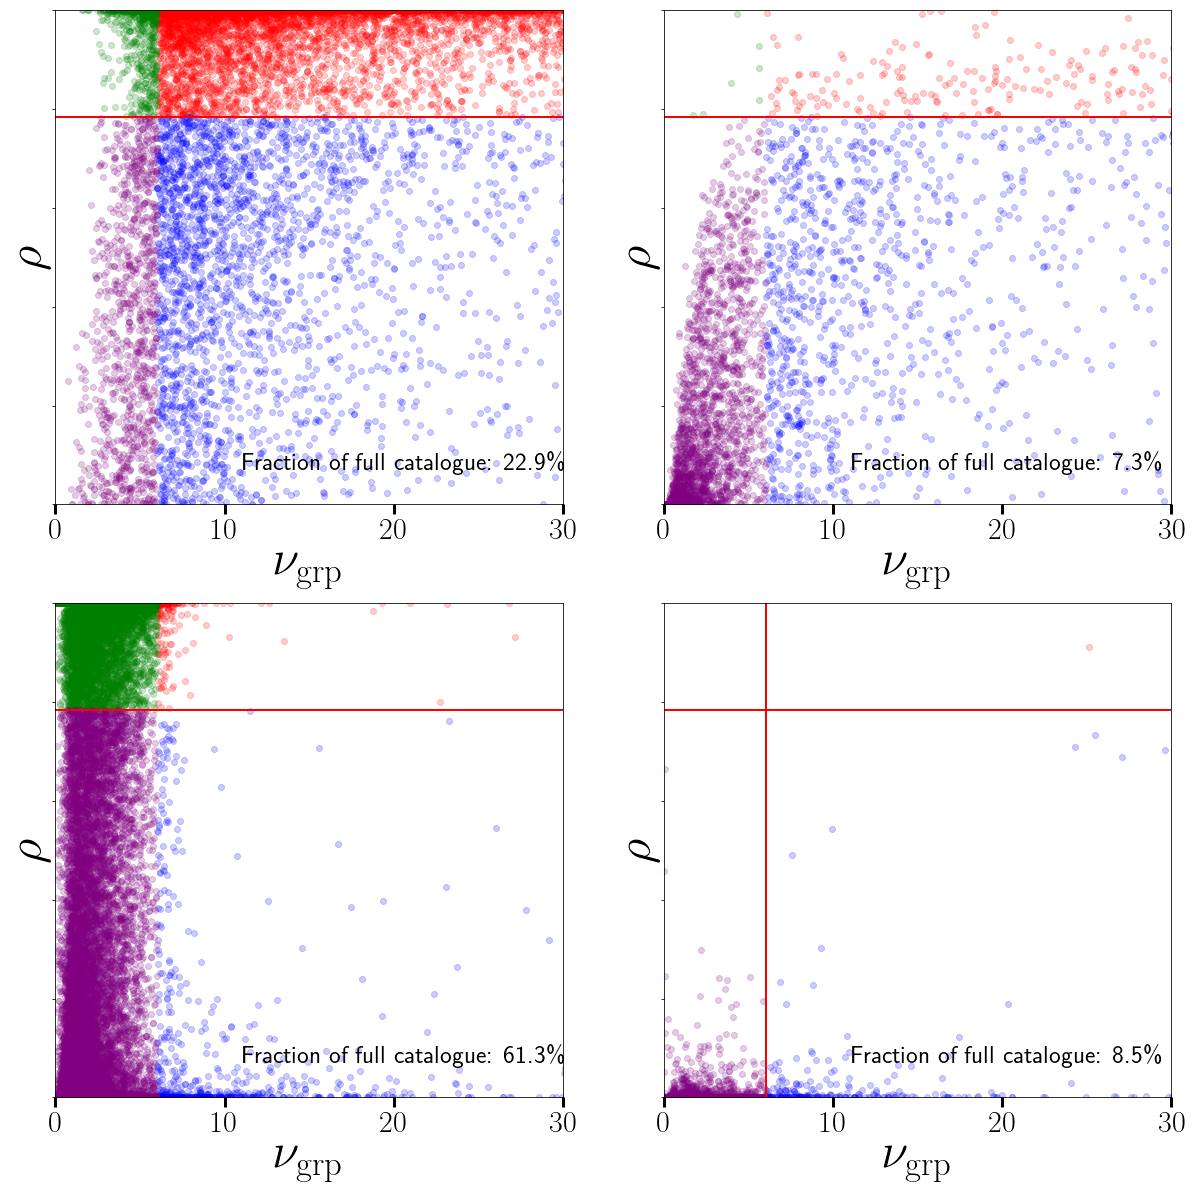

In [62]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 

name = 'All galaxies'
#'Detected and not ambiguously blended galaxies'
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]

colors= ['red', 'green', 'blue', 'purple','black']

for i,(cat_temp,name) in enumerate(zip(cats,names)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='red',linewidth=2)
    purity_snr_scatter_poster(name,cat_temp,colors,power,cat,ax)


plt.axvline(6,color='red',linewidth=2)
plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_1.pdf')

In [ ]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 1,2
power = 50. 

name = 'Not ambiguously blended and detected galaxies'
#'Detected and not ambiguously blended galaxies'
# cats =[cat, detc_and_notambig(cat)]
colors= ['red', 'green', 'blue', 'purple']

# for i,(cat_temp,name) in enumerate(zip(cats,names)):
#     plt.subplot(nrow, ncol, i+1)
# #     if name == 'Not detected and ambiguously blended galaxies':
# #         plt.axhline(.98,color='red',linewidth=2)
# #         purity_snr_scatter_poster(name,cat_temp,colors,cat,1.)
# #     else:
plt.axhline(.98**power,color='red',linewidth=2)
purity_snr_scatter_poster(name,best(cat),colors,power)


plt.axvline(6,color='red',linewidth=2)
plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_2.pdf')

# golden best  and good best sample plots 

In [72]:
names = ['Best golden sample','Best good sample']
cats =[gold(best(cat)),good(best(cat))]
colors = ('red','green')

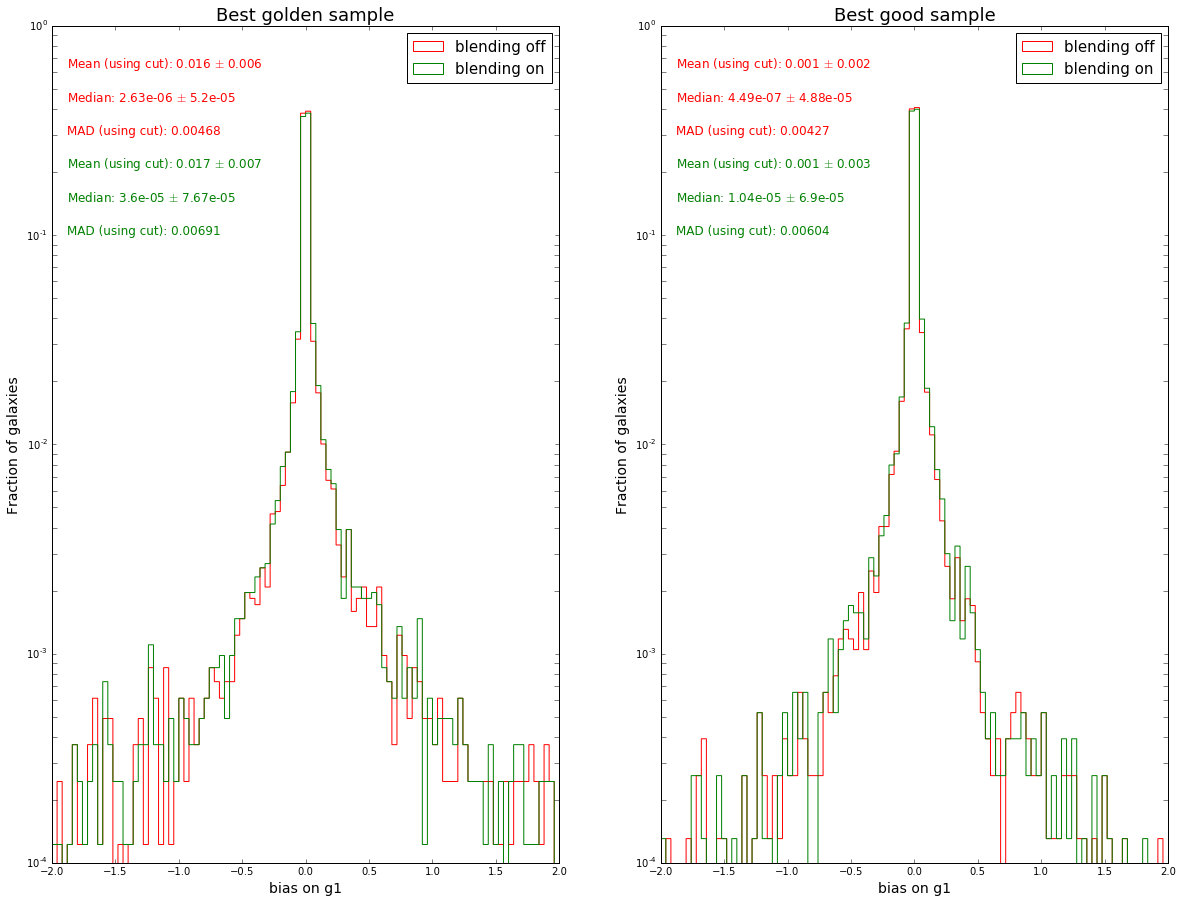

In [73]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 1,2
g_min = -2. 
g_max = 2.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})
    

In [74]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_hists_unclipped(name,cat,colors,g_min,g_max,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    
    #annotate 
    mean_cut_iso = np.mean(cut_biasiso(cat_temp,10.)['bias_g1'])
    std_cut_iso = np.std(cut_biasiso(cat_temp,10.)['bias_g1'])
    median_iso = np.median(cat_temp['bias_g1'])
    mad_iso = mad(cat_temp['bias_g1'])
    error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat_temp,10)))
    error_mad_iso = mad_iso/np.sqrt(len(cat_temp['bias_g1']))
    
    mean_cut_grp = np.mean(cut_biasgrp(cat_temp,10)['bias_g1_grp'])
    std_cut_grp = np.std(cut_biasgrp(cat_temp,10)['bias_g1_grp'])
    median_grp = np.median(cat_temp['bias_g1_grp'])
    mad_grp = mad(cat_temp['bias_g1_grp'])
    error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat_temp,10)))
    error_mad_grp = mad_grp/np.sqrt(len(cat_temp['bias_g1_grp']))
    
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('MAD: {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=12)
    plt.annotate('Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=12)
    plt.annotate('MAD: {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=12)

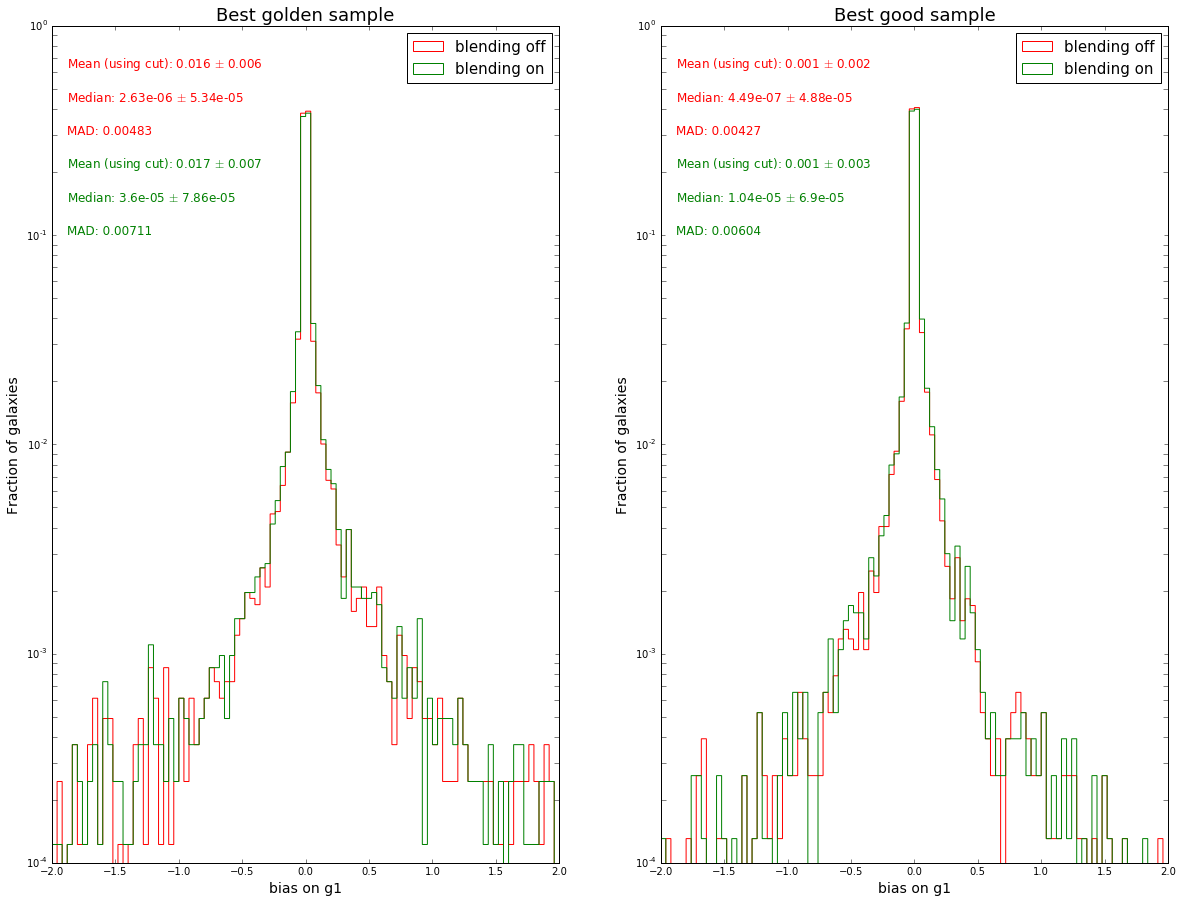

In [75]:
#does clipping make a difference
fig = plt.figure(figsize=(20,15))
nrow,ncol = 1,2
g_min = -2. 
g_max = 2.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists_unclipped(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})
    

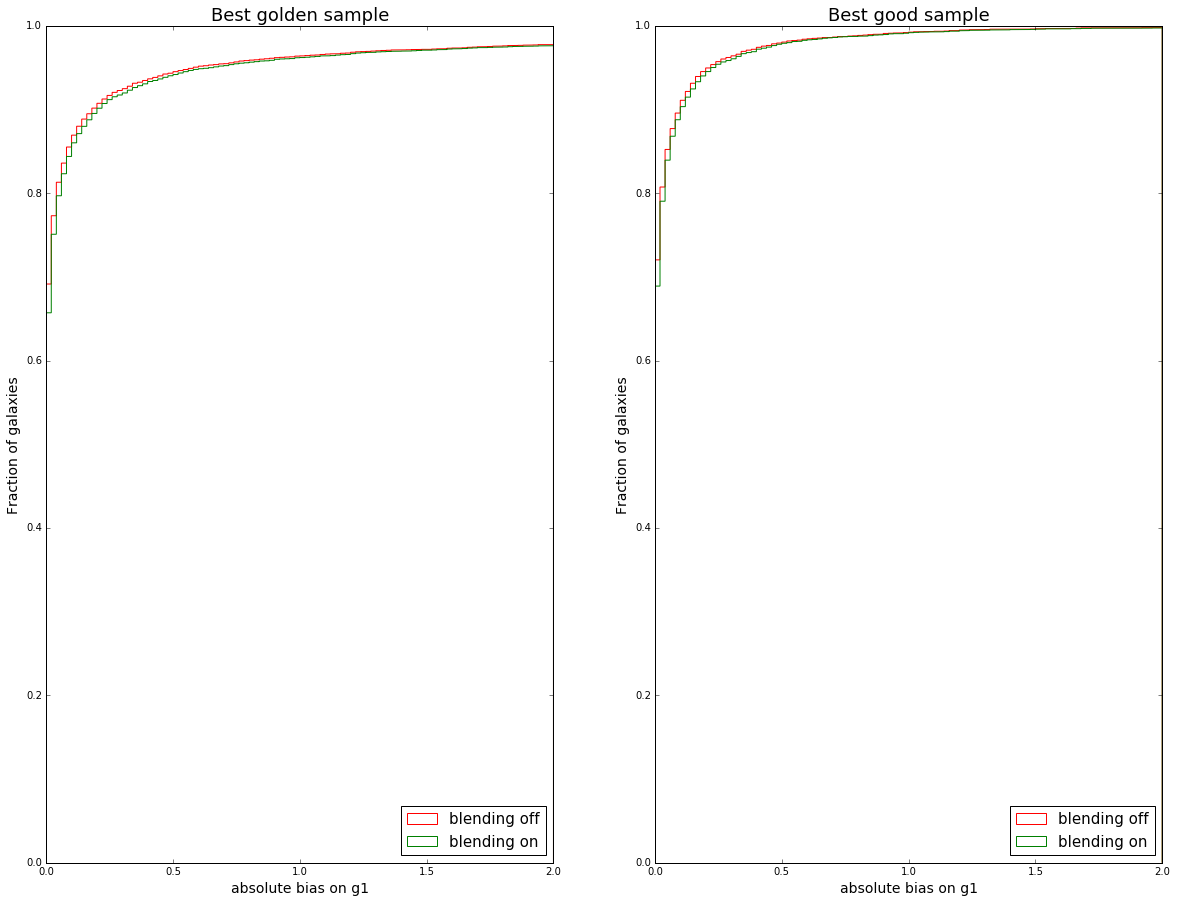

In [66]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 1,2
g_min = 0. 
g_max = 2.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_cumhists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15},loc=4)

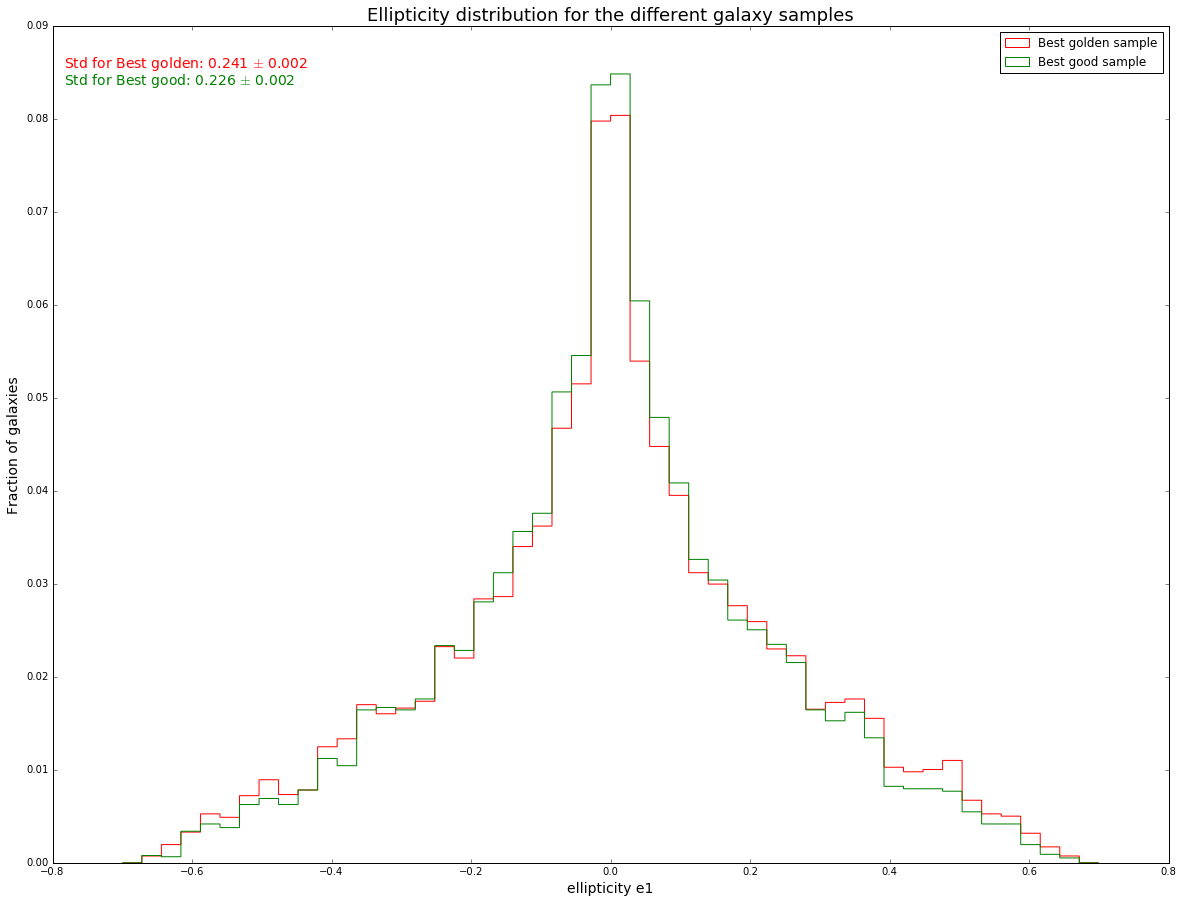

In [63]:
g_min = -.7 
g_max = .7
fig = plt.figure(figsize=(20,15))
names_stds = ['Best golden', 'Best good'] 
for i,(cat_temp,color,name,name_std) in enumerate(zip(cats,colors,names,names_stds)):
    ellipticity_hist(name,cat_temp,color,g_min,g_max)
    plt.legend(prop={'size':12})

In [ ]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 1,2
g_min = -2. 
g_max = 2.
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    plt.legend(prop={'size':15})
    plt.scatter
    

### 1d plots of purity and snr_grpf 


In [50]:
#produce different plots with the biases calculated from the fisher formalism. 
def purity_hists(name,cat,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel('Purity',fontsize=16)
    plt.ylabel('Fraction of galaxies',fontsize=16)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['purity'],histtype='step',bins=50,range=(0,1.),weights=np.ones_like(cat['purity'])/len(cat['purity']))

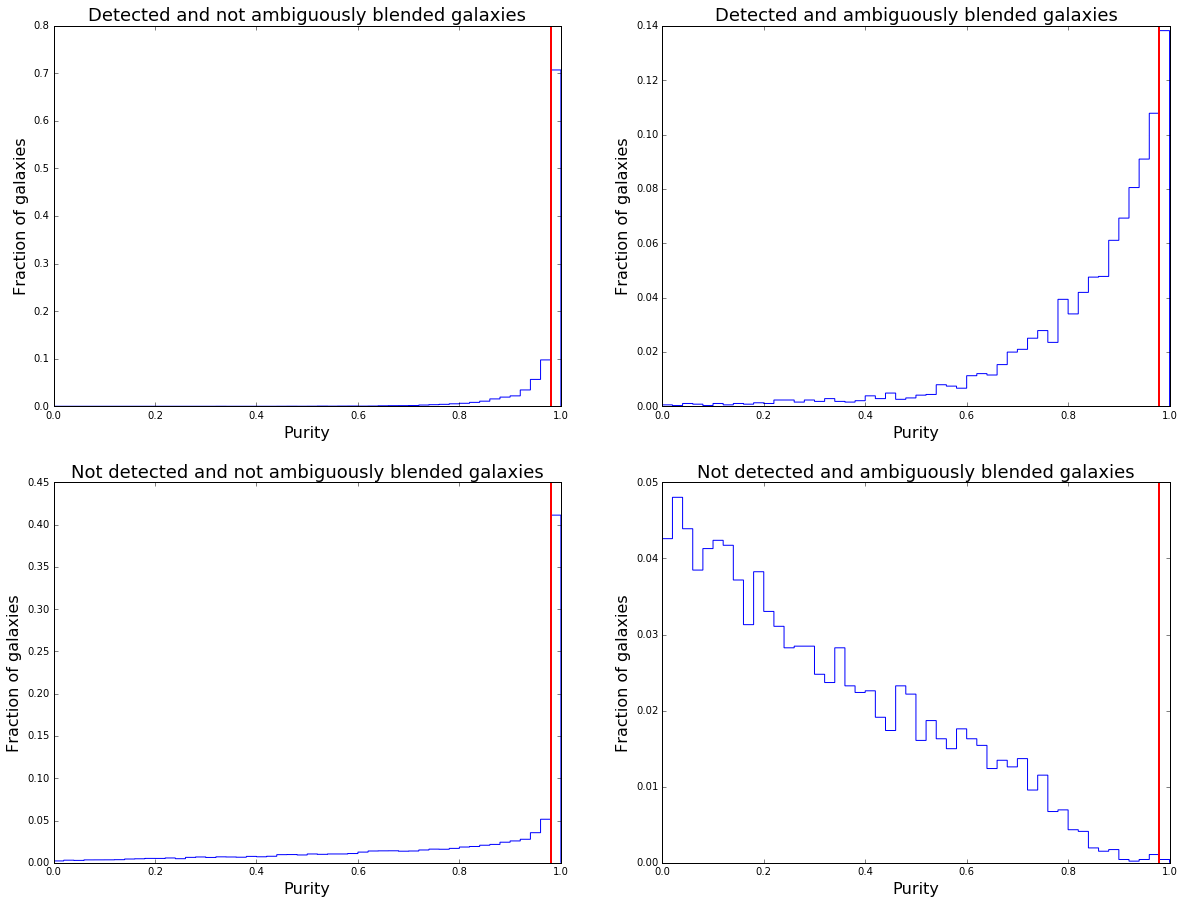

In [51]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2

names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]


for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    purity_hists(name,cat_temp)
    plt.axvline(.98,color='red',linewidth=2)


In [49]:
#produce different plots with the biases calculated from the fisher formalism. 
def snr_grpf_hists(name,cat,save=None):
    plt.title(name,fontsize=18)
    plt.xlabel(r'$\nu_{grpf}$',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['snr_grpf'],histtype='step',range=(0,30),weights=np.ones_like(cat['snr_grpf'])/len(cat['snr_grpf']))
    

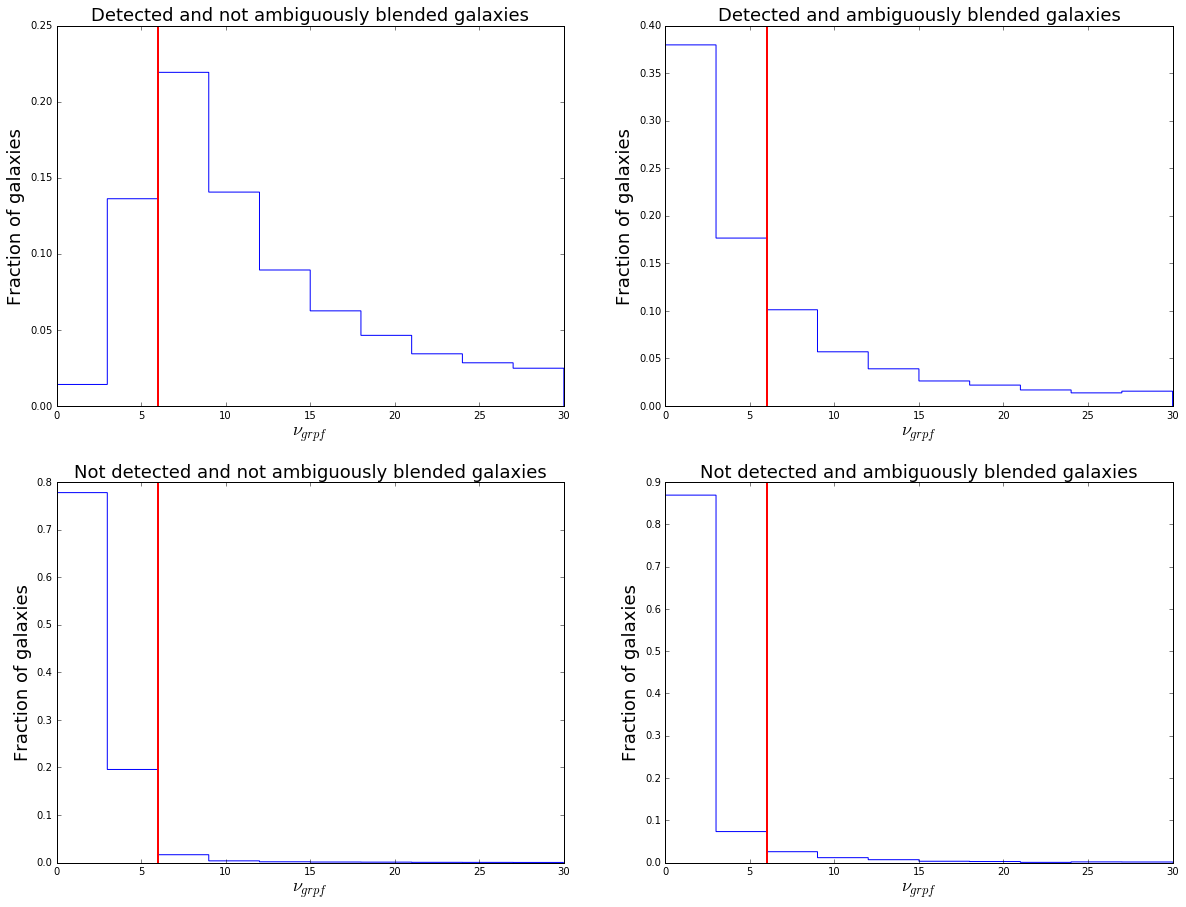

In [48]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2

names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']
cats =[detc_and_notambig(cat),detc_and_ambig(cat),notdetc_and_notambig(cat),notdetc_and_ambig(cat)]


for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    snr_grpf_hists(name,cat_temp)
    plt.axvline(6,color='red',linewidth=2)
    plt.xlim(0,30)


## Other

In [ ]:
def means(cat,name):
    print 'The ellipticity statistics for the {0} are:'.format(name)
    print 'Mean on e1: \n{0}\n'.format(np.mean(cat['e1']))
    print 'Median on e1: \n{0}\n'.format(np.median(cat['e1']))
    print 'Error on mean of e1 (using median standard deviation): \n{0}\n'.format(np.mad(cat['e1'])/np.sqrt(len(cat)))
    print 'Mean on e2: \n{0}\n'.format(np.mean(cat['e2']))
    print 'Median on e2: \n{0}\n'.format(np.median(cat['e2']))
    print 'Error on mean of e2: \n{0}\n'.format(np.mad(cat['e2'])/np.sqrt(len(cat)))
    #
    print 'The unblended biases statistics for the {0} are:'.format(name)
    print 'Mean on bias_g1: \n{0}\n'.format(np.mean(cat['bias_g1']))
    print 'Median on bias_g1: \n{0}\n'.format(np.median(cat['bias_g1']))
    print 'Standard Deviation on bias_g1: \n{0}\n'.format(np.mad(cat['bias_g1']))
    print 'Mean on bias_g2: \n{0}\n'.format(np.mean(cat['bias_g2']))
    print 'Median on bias_g2: \n{0}\n'.format(np.median(cat['bias_g2']))
    print 'Variance on bias_g2: \n{0}\n\n'.format(np.mad(cat['bias_g2'])) 
    #
    print 'The blended biases statistics for the {0} are:'.format(anme)
    print 'Mean on bias_g1_grp: \n{0}\n'.format(np.mean(cat['bias_g1_grp']))
    print 'Standard Deviation on bias_g1_grp: \n{0}\n'.format(np.std(cat['bias_g1_grp']))
    print 'Mean on bias_g2_grp: \n{0}\n'.format(np.mean(cat['bias_g2_grp']))
    print 'Standard Deviation on bias_g2_grp: \n{0}\n\n'.format(np.std(cat['bias_g2_grp'])) 

(array([  339.,   478.,   697.,  1375.,  9393.,  9357.,  1394.,   709.,
          454.,   368.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

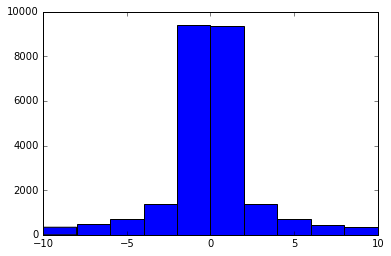

In [69]:
plt.figure()
plt.hist(notdetc_and_notambig(cat)['bias_g1'],range=[-10,10],histtype)

(array([   67.,   112.,   157.,   277.,  2786.,  2832.,   289.,   151.,
          113.,    83.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

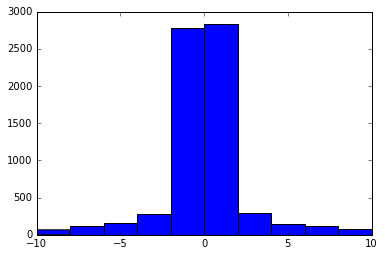

In [45]:
plt.figure()
plt.hist(ambig(cat)['bias_g1_grp'],range=[-10,10])

In [68]:
#results of some robust statistics
print medad(not_ambig(cat)['bias_g1'])
print medad(not_ambig(cat)['bias_g1_grp'])
print
print medad(ambig(cat)['bias_g1'])
print medad(ambig(cat)['bias_g1_grp'])
print
print medad(detc_and_notambig(cat)['bias_g1'])
print medad(detc_and_notambig(cat)['bias_g1_grp'])
print
print medad(detc_and_ambig(cat)['bias_g1'])
print medad(detc_and_ambig(cat)['bias_g1_grp'])
print
print medad(notdetc_and_notambig(cat)['bias_g1'])
print medad(notdetc_and_notambig(cat)['bias_g1_grp'])
print
print medad(notdetc_and_ambig(cat)['bias_g1'])
print medad(notdetc_and_ambig(cat)['bias_g1_grp'])
print

0.446748
0.613525

0.0761804
0.437891

0.0175742
0.0230037

0.00878191
0.0650698

1.16361
1.62127

0.337993
1.89757



In [ ]:
# now compare with original data. normalizing it probably. 
plt.figure()
plt.hist(table_ambig['bias_g1'])
plt.figure()
plt.hist(table_ambig['bias_g1_grp'])

# Other possible plots 

In [ ]:
def snr_plot(results,isolation_cut=0.98,detection_cut=6.,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Get our filter band.
    filter = hdr['FILTER_BAND'[-8:]].rstrip()
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
        np.count_nonzero(bad_snr),np.max(cat['snr_sky'][bad_snr]))
    visible = np.logical_and(np.logical_not(bad_snr),cat['visible']>0)
    num_visible = np.count_nonzero(visible)
    print 'Found %d visible sources (%.1f/sq.arcmin.)' % (num_visible,num_visible/area)
    # Calculate median SNR for each estimator.
    for est in ('sky','iso','grp','isof','grpf'):
        print 'Median snr_%s = %.3f' % (est,np.median(cat['snr_'+est][visible]))
    # Define our 'blended' sample.
    blended = np.logical_and(visible,cat['purity'] < isolation_cut)
    num_blended = np.count_nonzero(blended)
    print 'Found %d blended sources (%.1f/sq.arcmin.) with purity < %.3f = %.1f%% of visible sources' % (
        num_blended,num_blended/area,isolation_cut,100.*num_blended/num_visible)
    isolated = np.logical_and(visible,np.logical_not(blended))
    # Prepare labels (we do not call these 'isolated' and 'blended' since we are not requiring that they be detected)
    blended_label = '$\\rho < %.2f$' % isolation_cut
    isolated_label = '$\\rho \geq %.2f$' % isolation_cut
    # Define our 'disk' and 'bulge' samples.
    fcut = 0.1
    disk = np.logical_and(visible,cat['f_bulge']<fcut)
    bulge = np.logical_and(visible,cat['f_bulge']>=fcut)
    print 'Fraction of visible galaxies with f_bulge < %.1f is %.1f%%' % (
        fcut,100.*np.count_nonzero(disk)/num_visible)
    # Initialize figure.
    fig = plt.figure(figsize=(15,8))
    nrow,ncol = 2,3
    # snr_iso vs snr_isof
    plt.subplot(nrow,ncol,1)
    snr_min,snr_max=0.1,1e3
    snr_bins=np.logspace(np.log10(snr_min),np.log10(snr_max),50)
    plt.hist(cat['snr_iso'][visible],bins=snr_bins,histtype='step',color='black',linestyle='dashed',
        weights=area_wgt[visible],label='iso')
    plt.hist(cat['snr_isof'][visible],bins=snr_bins,histtype='step',color='black',
        weights=area_wgt[visible],label='isof')
    plt.hist(cat['snr_isof'][isolated],bins=snr_bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['snr_isof'][blended],bins=snr_bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate')
    plt.ylabel('Galaxies / sq.arcmin. / (SNR bin)')
    plt.legend()
    plt.annotate('(a)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_grp vs snr_grpf
    plt.subplot(nrow,ncol,2)
    plt.hist(cat['snr_grp'][visible],bins=snr_bins,histtype='step',color='black',linestyle='dashed',
        weights=area_wgt[visible],label='grp')
    plt.hist(cat['snr_grpf'][visible],bins=snr_bins,histtype='step',color='black',
        weights=area_wgt[visible],label='grpf')
    plt.hist(cat['snr_grpf'][isolated],bins=snr_bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['snr_grpf'][blended],bins=snr_bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate')
    plt.ylabel('Galaxies / sq.arcmin. / (SNR bin)')
    plt.legend()
    plt.annotate('(b)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # purity
    plt.subplot(nrow,ncol,3)
    bins = np.linspace(-0.05,1.05,111,endpoint=True)
    plt.hist(cat['purity'][isolated],bins=bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['purity'][blended],bins=bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xlim(bins[0],bins[-1])
    plt.xlabel('Galaxy Purity')
    plt.ylabel('Galaxies / sq.arcmin. / 0.02')
    plt.yscale('log')
    plt.ylim(0,200.)
    plt.legend(loc = 'upper center')
    plt.annotate('(c)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_sky vs snr_iso
    plt.subplot(nrow,ncol,4)
    plt.scatter(cat['snr_iso'][visible],cat['snr_iso'][visible]/cat['snr_sky'][visible],
        c=cat['ab_mag'][visible],s=8,lw=0,vmin=21.,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{iso}$')
    plt.ylabel('Signal-to-noise degradation $\\nu_{iso}/\\nu_{sky}$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(0.90,1.01)
    plt.colorbar(label='$%s_{AB}$ magnitude' % filter,pad=0.01)
    plt.annotate('(d)',xy=(0.1,0.8),xycoords='axes fraction',fontsize='large')
    # snr_iso vs snr_isof
    plt.subplot(nrow,ncol,5)
    w=disk
    z=cat['sigma_m'][w]
    zmin,zmax = np.percentile(z,(10.,90.))
    plt.scatter(cat['snr_iso'][w],cat['snr_isof'][w]/cat['snr_iso'][w],
        c=z,vmin=zmin,vmax=zmax,s=8,lw=0,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{iso}$')
    plt.ylabel('Signal-to-noise degradation $\\nu_{isof}/\\nu_{iso}$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(0.0,0.8)
    plt.colorbar(label='Galaxy size $\sigma_{-}$ (arcseconds)',pad=0.01)
    plt.annotate('(e)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_grpf vs purity
    plt.subplot(nrow,ncol,6)
    w=visible
    z=cat['snr_grpf'][w]/cat['snr_iso'][w]
    zmin,zmax = np.percentile(z,(10.,90.))
    plt.scatter(cat['snr_grpf'][w],cat['purity'][w],
        c=z,vmin=zmin,vmax=zmax,s=8,lw=0,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{grpf}$')
    plt.ylabel('Purity $\\rho$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(-0.05,1.05)
    plt.colorbar(label='SNR degradation $\\nu_{grpf}/\\nu_{iso}$',pad=0.01)
    plt.annotate('',xy=(snr_min,isolation_cut),xytext=(snr_max,isolation_cut),xycoords='data',textcoords='data',
        arrowprops={'arrowstyle':'-','color':'black','linewidth':3,'linestyle':'dashed'})
    if detection_cut is not None:
        plt.annotate('',xy=(detection_cut,-0.05),xytext=(detection_cut,1.05),xycoords='data',textcoords='data',
            arrowprops={'arrowstyle':'-','color':'black','linewidth':3,'linestyle':'dashed'})
    plt.annotate('(f)',xy=(0.9,0.1),xycoords='axes fraction',fontsize='large')
    #
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

### plots from before 

In [ ]:
#number of galaxies in each category
def basic_stats(cat, good, gold):
    print 'total number of galaxies is {0}'.format(len(cat))
    print 'total number of isolated galaxies is {0}, they constitute {1:.2f}% of the total.'.format(len(iso_gal(cat)), float(len(iso_gal(cat)))/len(cat)*100)
    print 'total number of non-isolated galaxies is {0}, they constitute {1:.2f}% of the total.'.format(len(grp_gal(cat)), float(len(grp_gal(cat)))/len(cat)*100)
    print 'total number of good galaxies is {0}, they constitute {1:.2f}% of the total.'.format(len(good), float(len(good))/len(cat)*100)
    print 'total number of good isolated galaxies is {0}, they constitute {1:.2f}% of the isolated galaxies, and {2:.2f}% of the total.'.format(len(iso_gal(good)),float(len(iso_gal(good)))/len(iso_gal(cat))*100, float(len(iso_gal(good)))/len(cat)*100)
    print 'total number of good non-isolated galaxies is {0}, they constitute {1:.2f}% of the non-isolated galaxies, and {2:.2f}% of the total.'.format(len(grp_gal(good)), float(len(grp_gal(good)))/len(grp_gal(cat))*100,  float(len(grp_gal(good)))/len(cat)*100)
    print 'total number of gold galaxies is {0}, they constitute {1:.2f}% of the total.'.format(len(gold), float(len(gold))/len(cat)*100)
    print 'total number of gold isolated galaxies is {0}, they constitute {1:.2f}% of the isolated galaxies, and {2:.2f}% of the total.'.format(len(iso_gal(gold)),float(len(iso_gal(gold)))/len(iso_gal(cat))*100, float(len(iso_gal(gold)))/len(cat)*100)
    print 'total number of gold non-isolated galaxies is {0}, they constitute {1:.2f}% of the non-isolated galaxies, and {2:.2f}% of the total.'.format(len(grp_gal(gold)),float(len(grp_gal(gold)))/len(grp_gal(cat))*100, float(len(grp_gal(gold)))/len(cat)*100)



In [ ]:
def means(cat,good,gold):
    print 'The ellipticity statistics for the catalog are:'
    print 'Mean on e1: \n{0}\n'.format(np.mean(cat['e1']))
    print 'Error on mean of e1: \n{0}\n'.format(np.std(cat['e1'])/np.sqrt(len(cat))) 
    print 'Mean on e2: \n{0}\n'.format(np.mean(cat['e2']))
    print 'Error on mean of e2: \n{0}\n'.format(np.std(cat['e2'])/np.sqrt(len(cat)))
    #
    print 'The ellipticity statistics for the good galaxies of the catalog are:'
    print 'Mean on e1: \n{0}\n'.format(np.mean(good['e1']))
    print 'Error on mean of e1: \n{0}\n'.format(np.std(good['e1'])/np.sqrt(len(good))) 
    print 'Mean on e2: \n{0}\n'.format(np.mean(good['e2']))
    print 'Error on mean of e2: \n{0}\n'.format(np.std(good['e2'])/np.sqrt(len(good)))      
    #
    print 'The ellipticity statistics for the gold galaxies of the catalog are:'
    print 'Mean on e1: \n{0}\n'.format(np.mean(gold['e1']))
    print 'Error on mean of e1: \n{0}\n'.format(np.std(gold['e1'])/np.sqrt(len(gold))) 
    print 'Mean on e2: \n{0}\n'.format(np.mean(gold['e2']))
    print 'Error on mean of e2: \n{0}\n'.format(np.std(gold['e2'])/np.sqrt(len(gold)))    
    #
    print 'The unblended biases statistics for the catalog are:'
    print 'Mean on bias_g1: \n{0}\n'.format(np.mean(cat['bias_g1']))
    print 'Standard Deviation on bias_g1: \n{0}\n'.format(np.std(cat['bias_g1']))
    print 'Mean on bias_g2: \n{0}\n'.format(np.mean(cat['bias_g2']))
    print 'Variance on bias_g2: \n{0}\n\n'.format(np.std(cat['bias_g2'])) 
    #
    print 'The blended biases statistics for the catalog are:'
    print 'Mean on bias_g1_grp: \n{0}\n'.format(np.mean(cat['bias_g1_grp']))
    print 'Standard Deviation on bias_g1_grp: \n{0}\n'.format(np.std(cat['bias_g1_grp']))
    print 'Mean on bias_g2_grp: \n{0}\n'.format(np.mean(cat['bias_g2_grp']))
    print 'Standard Deviation on bias_g2_grp: \n{0}\n\n'.format(np.std(cat['bias_g2_grp'])) 
    #
    #

    good_cut_iso= good[(abs(good['bias_g1']) < 10) & (abs(good['bias_g2']) < 10)]
    good_cut_grp= good[(abs(good['bias_g1_grp']) < 10) & (abs(good['bias_g2_grp']) < 10)]
    print 'The unblended biases statistics for the good galaxies of the catalog are:'
    print 'Mean on bias_g1: \n{0}\n'.format(np.mean(good_cut_iso['bias_g1']))
    print 'Error on mean of bias_g1: \n{0}\n'.format(np.std(good_cut_iso['bias_g1'])/np.sqrt(len(good_cut_iso)))
    print 'Mean on bias_g2: \n{0}\n'.format(np.mean(good_cut_iso['bias_g2']))
    print 'Error on mean of bias_g2: \n{0}\n\n'.format(np.std(good_cut_iso['bias_g2'])/np.sqrt(len(good_cut_iso))) 
    #
    print 'The blended biases statistics for the good galaxies of the catalog are:'
    print 'Mean on bias_g1_grp: \n{0}\n'.format(np.mean(good_cut_grp['bias_g1_grp']))
    print 'Error on mean of bias_g1_grp: \n{0}\n'.format(np.std(good_cut_grp['bias_g1_grp'])/np.sqrt(len(good_cut_grp)))
    print 'Mean on bias_g2_grp: \n{0}\n'.format(np.mean(good_cut_grp['bias_g2_grp']))
    print 'Error on mean of bias_g2_grp: \n{0}\n'.format(np.std(good_cut_grp['bias_g2_grp'])/np.sqrt(len(good_cut_grp))) 

    #
    #
    gold_cut_iso= gold[(abs(gold['bias_g1']) < 10) & (abs(gold['bias_g2']) < 10)]
    gold_cut_grp= gold[(abs(gold['bias_g1_grp']) < 10) & (abs(gold['bias_g2_grp']) < 10)]
    print 'The unblended biases statistics for the gold galaxies of the catalog are:'
    print 'Mean on bias_g1: \n{0}\n'.format(np.mean(gold_cut_iso['bias_g1']))
    print 'Error on mean of bias_g1: \n{0}\n'.format(np.std(gold_cut_iso['bias_g1'])/np.sqrt(len(gold_cut_iso)))
    print 'Mean on bias_g2: \n{0}\n'.format(np.mean(gold_cut_iso['bias_g2']))
    print 'Error on mean of bias_g2: \n{0}\n\n'.format(np.std(gold_cut_iso['bias_g2'])/np.sqrt(len(gold_cut_iso))) 
    #
    print 'The blended biases statistics for the gold galaxies of the catalog are:'
    print 'Mean on bias_g1_grp: \n{0}\n'.format(np.mean(gold_cut_grp['bias_g1_grp']))
    print 'Error on mean of bias_g1_grp: \n{0}\n'.format(np.std(gold_cut_grp['bias_g1_grp'])/np.sqrt(len(gold_cut_grp)))
    print 'Mean on bias_g2_grp: \n{0}\n'.format(np.mean(gold_cut_grp['bias_g2_grp']))
    print 'Error on mean of bias_g2_grp: \n{0}\n'.format(np.std(gold_cut_grp['bias_g2_grp'])/np.sqrt(len(gold_cut_grp))) 

In [ ]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_plots2(cat,good,gold,save=None):
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 2,1

    #
    plt.subplot(nrow, ncol, 1) 
    plt.title('biases on g1 galaxies',fontsize=14)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_all',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g1_grp_all',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_good',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    plt.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',label='bias_g1_grp_good',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(gold['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g1_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g1']))
    plt.hist(gold['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='gold',histtype='step',label='bias_g1_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    #
    plt.subplot(nrow, ncol, 2) 
    plt.tick_params(axis='both', which='minor',size=5)
    plt.title('biases on g2',fontsize=14)
    plt.xlabel('bias on g2',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    #
    plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
    plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
    plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
    plt.legend()
    #
    plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
    plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
    plt.legend()
    plt.yscale('log')

In [ ]:
#some plot from the notebook ShearEstimatorPlots using biases from the Fisher Formalism. 
#made a cut on biases for g1 and g2 in range (-2,2)
def purity_bias_shears(cat,good, gold, save=None):
    selected_cat = (cat['bias_g1'] < 2.) & (cat['bias_g1'] > -2.) & (cat['bias_g2'] < 2.) & (cat['bias_g2'] > -2.) #makes plot more feasible
    selected_good = (good['bias_g1'] < 2.) & (good['bias_g1'] > -2.) & (good['bias_g2'] < 2.) & (good['bias_g2'] > -2.)
    selected_gold = (gold['bias_g1'] < 2.) & (gold['bias_g1'] > -2.) & (gold['bias_g2'] < 2.) & (gold['bias_g2'] > -2.)
    selected_cat_grp = (cat['bias_g1_grp'] < 2.) & (cat['bias_g1_grp'] > -2.) & (cat['bias_g2_grp'] < 2.) & (cat['bias_g2_grp'] > -2.) #makes plot more feasible
    selected_good_grp = (good['bias_g1_grp'] < 2.) & (good['bias_g1_grp'] > -2.) & (good['bias_g2_grp'] < 2.) & (good['bias_g2_grp'] > -2.)
    selected_gold_grp = (gold['bias_g1_grp'] < 2.) & (gold['bias_g1_grp'] > -2.) & (gold['bias_g2_grp'] < 2.) & (gold['bias_g2_grp'] > -2.)
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 3,2
    #
    plt.subplot(nrow,ncol,1)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat]['purity'] >= xlo) & (cat[selected_cat]['purity'] < xhi)
        dg1 = cat[selected_cat]['bias_g1'][in_range]
        dg2 = cat[selected_cat]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    ##
    plt.tight_layout()

    #
    
    plt.subplot(nrow,ncol,2)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat_grp]['purity'] >= xlo) & (cat[selected_cat_grp]['purity'] < xhi)
        dg1 = cat[selected_cat_grp]['bias_g1_grp'][in_range]
        dg2 = cat[selected_cat_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.axhline(0,color='green')
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,3)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good]['purity'] >= xlo) & (good[selected_good]['purity'] < xhi)
        dg1 = good[selected_good]['bias_g1'][in_range]
        dg2 = good[selected_good]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.axhline(0,color='green')


    ##
    plt.tight_layout()
    #
    plt.subplot(nrow,ncol,4)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good_grp]['purity'] >= xlo) & (good[selected_good_grp]['purity'] < xhi)
        dg1 = good[selected_good_grp]['bias_g1_grp'][in_range]
        dg2 = good[selected_good_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    plt.subplot(nrow,ncol,5)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold]['purity'] >= xlo) & (gold[selected_gold]['purity'] < xhi)
        dg1 = gold[selected_gold]['bias_g1'][in_range]
        dg2 = gold[selected_gold]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,6)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold_grp]['purity'] >= xlo) & (gold[selected_gold_grp]['purity'] < xhi)
        dg1 = gold[selected_gold_grp]['bias_g1_grp'][in_range]
        dg2 = gold[selected_gold_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    

In [ ]:
def cumulative_histograms2(cat,good,gold):
    fig = plt.figure(figsize=(20,20))
    nrow,ncol = 2,1
    #
    plt.subplot(nrow,ncol,1)
    plt.hist(cat['grp_size'],histtype='step',bins=600,range=[0,600],color='red',label='all',cumulative=True,normed=True)
    plt.xlabel('grp_size',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.xlim(1,50)
    plt.ylim(0,1)
    plt.title('Cumulative histogram of grp_size',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15,width=2)
    #
    plt.hist(good['grp_size'],histtype='step',bins=600,range=([0,600]),label='good',color='blue',cumulative=True,normed=True)
    #
    plt.hist(gold['grp_size'],bins=600,range=([0,600]),histtype='step',label='gold',cumulative=True,color='gold',normed=True)
    plt.legend(loc=2,prop={'size':20})
    #
    #
    plt.subplot(nrow,ncol,2)
    plt.hist(cat['purity'], bins=50,histtype='step',color='red',label='all',weights=np.ones_like(cat['purity'])/len(cat['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.title('Histogram of purity',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #
    plt.hist(good['purity'], bins=50,histtype='step',color='blue',label='good',weights=np.ones_like(good['purity'])/len(good['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=12,width=2)
    plt.tick_params(axis='both', which='minor',size=5)


    #
    plt.hist(gold['purity'], bins=50,histtype='step',color='gold',label='gold',weights=np.ones_like(gold['purity'])/len(gold['purity']))
    plt.xlabel('Purity',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=15)


    
    plt.legend(loc=2,prop={'size':20})




In [ ]:
def histograms_abmag(cat,good):
    plt.figure()
    plt.hist(cat['ab_mag'], histtype='step', bins=50,label='all galaxies',range=(14,30))
    plt.xlabel('ab_mag',fontsize=14)
    plt.title('Histogram of ab_mag for all galaxies')
    plt.axvline(25.3,color='green',label='cut for golden sample') #this represents the gold sample cut. 
    #
    plt.hist(good['ab_mag'], histtype='step',bins=50,color='red',label='good galaxies',range=(14,30))
    plt.xlabel('ab_mag',fontsize=14)
    plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2)



In [ ]:
#similar plots but with bias on flux
def flux_biases_plots(good,gold,save=None):
    f_min = -3
    f_max = 3
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 1,2
    frac_bflux_g = good['bias_f']/good['flux']
    frac_bflux_grpg = good['bias_f_grp']/good['flux']
    frac_bflux_gold = gold['bias_f']/gold['flux']e
    frac_bflux_grpgold = gold['bias_f_grp']/gold['flux']
    #
    plt.subplot(nrow, ncol, 1) 
    plt.hist(frac_bflux_g,range=[f_min,f_max],bins=100,histtype='step',label='bias_f/flux')
    plt.hist(frac_bflux_grpg,range=[f_min,f_max],bins=100,color='red',histtype='step',label='bias_f_grp/flux')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on flux for good galaxies',fontsize=18)
    plt.xlabel('bias on flux/flux',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    #
    plt.subplot(nrow, ncol, 2) 
    plt.hist(frac_bflux_gold,range=[f_min,f_max],bins=100,histtype='step',label='bias_f/flux')
    plt.hist(frac_bflux_grpgold,range=[f_min,f_max],bins=100,color='red',histtype='step',label='bias_f_grp/flux')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on flux for gold galaxies',fontsize=18)
    plt.xlabel('bias on flux/flux',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)